<a href="https://colab.research.google.com/github/dinuwanfernando/BTCUSD_model/blob/main/BTCUSD_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
import matplotlib.pyplot as plt
!pip install prophet
from prophet import Prophet
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [3]:
%pip install oandapyV20
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.contrib.requests import MarketOrderRequest
access_token = "25828916746768cb5cf6f0ec2b97218e-0b9185adf70ecd8cf1b53bb781a4b1f3"
%pip install git+https://github.com/yhilpisch/tpqoa.git
api = oandapyV20.API(access_token=access_token)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69779 sha256=26cef6b1ad1a0b726520dfddcbe55da1e7a5fd67a2787cd328c830cff74cd6bc
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20
  Cloning https://github.com/yhilpisch/tpqoa.git to /tmp/pip-req-build-wv_91ifo
  Running command git clone --filter=blob:none --quiet https://github.com/yhilpisch/tpqoa.git /tmp/pip-req-build-wv_91ifo
  Resolved https://github.com/yhilpisch/tpqoa.git to commit 4a79f30b7095642844ef99741d9bfcb952e394db
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 6.0 MB/s eta 0:00:00
  Created wheel for tpqoa: filename=tpq

In [4]:
import tpqoa
oanda = tpqoa.tpqoa("/content/drive/MyDrive/ML BTCUSD model/oanda.cfg.txt")

In [5]:
# Function to download historical data using Oanda API
def get_historical_data(instrument, start, end, granularity, price):
    oanda = tpqoa.tpqoa("/content/drive/MyDrive/ML BTCUSD model/oanda.cfg.txt")  # Update path if needed
    df = oanda.get_history(instrument=instrument, start=start, end=end, granularity=granularity, price=price)
    return df.dropna()


In [6]:
date_var= '2024-04-02'

In [7]:
df_BTC_pp_01= oanda.get_history(instrument= 'BTC_USD', start= '2014-05-07', end='2016-05-06', granularity= 'H1', price='M')
df_BTC_pp_02= oanda.get_history(instrument= 'BTC_USD', start= '2016-05-07', end='2018-05-06', granularity= 'H1', price='M')
df_BTC_pp_03= oanda.get_history(instrument= 'BTC_USD', start= '2018-05-07', end='2020-05-06', granularity= 'H1', price='M')
df_BTC_pp_04= oanda.get_history(instrument= 'BTC_USD', start= '2020-05-07', end='2022-05-06', granularity= 'H1', price='M')
df_BTC_pp_05= oanda.get_history(instrument= 'BTC_USD', start= '2022-05-07', end='2023-05-06', granularity= 'H1', price='M')
df_BTC_pp_06= oanda.get_history(instrument= 'BTC_USD', start= '2023-05-07', end='2024-01-06', granularity= 'H1', price='M')
df_BTC_pp_07= oanda.get_history(instrument= 'BTC_USD', start= '2024-01-07', end=date_var, granularity= 'H1', price='M')

In [11]:
df_btc_p= pd.concat([df_BTC_pp_01,df_BTC_pp_02,df_BTC_pp_03,df_BTC_pp_04,df_BTC_pp_05,df_BTC_pp_06,
df_BTC_pp_07],axis=0).dropna()
df_btc_p.index= pd.to_datetime(df_btc_p.index)
df_btc_p= df_btc_p[df_btc_p.index < date_var].dropna()
###df_btc_dat.index= df_btc_data.index.date to add the time back
df_btc_p = df_btc_p.rename_axis('Date')
df_btc_p.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close','volume':'btc_volume'}, inplace=True)
df_btc_p= df_btc_p[['open','high','low','close']]
df_btc_p1=df_btc_p.astype(float)
print(df_btc_p1)
df_btc_p1.dtypes

                        open     high      low    close
Date                                                   
2016-01-01 06:00:00    436.8    437.0    433.0    435.5
2016-01-01 07:00:00    435.5    437.2    434.9    435.3
2016-01-01 08:00:00    435.3    436.8    433.3    435.5
2016-01-01 09:00:00    435.5    435.9    434.1    434.5
2016-01-01 10:00:00    434.5    435.9    433.4    433.9
...                      ...      ...      ...      ...
2024-04-01 19:00:00  68943.0  69872.7  68908.3  69705.6
2024-04-01 20:00:00  69705.1  69833.6  69367.2  69755.8
2024-04-01 21:00:00  69642.0  69951.2  69578.6  69620.8
2024-04-01 22:00:00  69623.0  69893.8  69614.4  69738.8
2024-04-01 23:00:00  69740.6  69909.6  69672.0  69686.2

[54893 rows x 4 columns]


open     float64
high     float64
low      float64
close    float64
dtype: object

In [ ]:
# Function to create features for classification and target variable indicating tomorrow's price movement (up or down).

#def create_classification_features(df):

  #df['Open-Close'] = df['open'] - df['btc_close']  # Change in price from Open to Close
  #df['High-Low'] = df['high'] - df['low']  # Daily price range
  #df = df.dropna()  # Remove rows with missing values after creating new features
  #X = df[['Open-Close', 'High-Low']]  # Features for classification
  #Y = np.where(df['btc_close'].shift(-1) > df['btc_close'], 1, -1)
  # Target variable: 1 if tomorrow's close is higher, -1 if lower
  #return X, Y


In [ ]:
df=df_btc_p1

In [ ]:
df.open

Date
2016-01-01 06:00:00      436.8
2016-01-01 07:00:00      435.5
2016-01-01 08:00:00      435.3
2016-01-01 09:00:00      435.5
2016-01-01 10:00:00      434.5
                        ...   
2024-04-01 19:00:00    68943.0
2024-04-01 20:00:00    69705.1
2024-04-01 21:00:00    69642.0
2024-04-01 22:00:00    69623.0
2024-04-01 23:00:00    69740.6
Name: open, Length: 54893, dtype: float64

In [ ]:
def create_classification_training_condition(df):

  df['Open-Close'] = df.open - df.close
  df['High-Low'] = df.high - df.low
  df = df.dropna()
  X=df[['Open-Close','High-Low']]
  Y=np.where(df['close'].shift(-1) > df['close'],1,-1)

  return (X,Y)


In [ ]:
def create_regression_trading_condition(df):
  df['Open-Close'] = df.open - df.close
  df['High-Low'] = df.high - df.low
  df = df.dropna()
  X = df[['Open-Close', 'High-Low']]
  Y = df['close'].shift(-1) - df['close']
  return (X, Y)

In [ ]:
df

,open,high,low,close
Date,,,,
2016-01-01 06:00:00,436.8,437.0,433.0,435.5
2016-01-01 07:00:00,435.5,437.2,434.9,435.3
2016-01-01 08:00:00,435.3,436.8,433.3,435.5
2016-01-01 09:00:00,435.5,435.9,434.1,434.5
2016-01-01 10:00:00,434.5,435.9,433.4,433.9
...,...,...,...,...
2024-04-01 19:00:00,68943.0,69872.7,68908.3,69705.6
2024-04-01 20:00:00,69705.1,69833.6,69367.2,69755.8
2024-04-01 21:00:00,69642.0,69951.2,69578.6,69620.8


In [ ]:
# Generate features and target variable
X, Y = create_regression_trading_condition(df)

In [ ]:
df

,open,high,low,close,Open-Close,High-Low
Date,,,,,,
2016-01-01 06:00:00,436.8,437.0,433.0,435.5,1.3,4.0
2016-01-01 07:00:00,435.5,437.2,434.9,435.3,0.2,2.3
2016-01-01 08:00:00,435.3,436.8,433.3,435.5,-0.2,3.5
2016-01-01 09:00:00,435.5,435.9,434.1,434.5,1.0,1.8
2016-01-01 10:00:00,434.5,435.9,433.4,433.9,0.6,2.5
...,...,...,...,...,...,...
2024-04-01 19:00:00,68943.0,69872.7,68908.3,69705.6,-762.6,964.4
2024-04-01 20:00:00,69705.1,69833.6,69367.2,69755.8,-50.7,466.4
2024-04-01 21:00:00,69642.0,69951.2,69578.6,69620.8,21.2,372.6


In [ ]:
from sklearn.model_selection import train_test_split

def create_train_split_group(X, Y, split_ratio=0.8):
  return train_test_split(X, Y, shuffle=False, train_size=split_ratio) #80% from entire dataset to train and 20% to testing

In [ ]:
print(X)

                     Open-Close  High-Low
Date                                     
2016-01-01 06:00:00         1.3       4.0
2016-01-01 07:00:00         0.2       2.3
2016-01-01 08:00:00        -0.2       3.5
2016-01-01 09:00:00         1.0       1.8
2016-01-01 10:00:00         0.6       2.5
...                         ...       ...
2024-04-01 19:00:00      -762.6     964.4
2024-04-01 20:00:00       -50.7     466.4
2024-04-01 21:00:00        21.2     372.6
2024-04-01 22:00:00      -115.8     279.4
2024-04-01 23:00:00        54.4     237.6

[54893 rows x 2 columns]


array([[<Axes: xlabel='Open-Close', ylabel='Open-Close'>,
        <Axes: xlabel='High-Low', ylabel='Open-Close'>,
        <Axes: xlabel='close', ylabel='Open-Close'>],
       [<Axes: xlabel='Open-Close', ylabel='High-Low'>,
        <Axes: xlabel='High-Low', ylabel='High-Low'>,
        <Axes: xlabel='close', ylabel='High-Low'>],
       [<Axes: xlabel='Open-Close', ylabel='close'>,
        <Axes: xlabel='High-Low', ylabel='close'>,
        <Axes: xlabel='close', ylabel='close'>]], dtype=object)

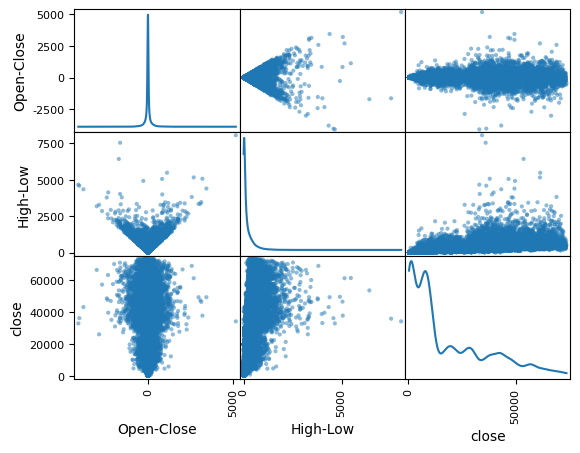

In [ ]:
#Plotting using conepts of Ordinary Least Squares
pd.plotting.scatter_matrix(df_btc_p1[['Open-Close', 'High-Low','close']], grid=True, diagonal='kde')

In [ ]:
#split 80% of the available data into the training feature value and target variable set (X_train, Y_train), and the remaining 20%
#of the dataset into the out-sample testing feature value and target variable set (X_test, Y_test)
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

In [ ]:
# Calculate rolling mean and rolling standard deviation
#def calculate_rolling_stats(df, window):
    #df['RollingMean'] = df['close'].rolling(window=window).mean()
    #df['RollingStd'] = df['close'].rolling(window=window).std()
    #return df.dropna()

In [ ]:
# Define trading signals based on mean reversion
#def mean_reversion_signals(df):
    #df['Signal'] = 0  # Initialize signal column
    # Buy signal: price below rolling mean minus one standard deviation
    #df.loc[df['close'] < (df['RollingMean'] - df['RollingStd']), 'Signal'] = 1
    # Sell signal: price above rolling mean plus one standard deviation
    #df.loc[df['close'] > (df['RollingMean'] + df['RollingStd']), 'Signal'] = -1
    #return df

In [ ]:
# Backtest the strategy
#def backtest_mean_reversion(df):
    #df = calculate_rolling_stats(df, window=20)  # Adjust window size as needed
    #df = mean_reversion_signals(df)
    #df['Returns'] = df['close'].pct_change()
    #df['StrategyReturns'] = df['Returns'] * df['Signal'].shift(1)
    #df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod()
    #return df

In [ ]:
# Plot cumulative returns
#def plot_cumulative_returns(df):
    #plt.figure(figsize=(10, 6))
    #plt.plot(df.index, df['CumulativeReturns'], label='Mean Reversion Strategy')
    #plt.title('Cumulative Returns')
    #plt.xlabel('Date')
    #plt.ylabel('Cumulative Returns')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

In [ ]:
# Backtest the mean reversion strategy
#df_backtest = backtest_mean_reversion(df.copy())

In [ ]:
# Plot cumulative returns
#plot_cumulative_returns(df_backtest)

Applying the DUAL MOVING AVERAGE Strategy

In [ ]:
#Create a function for the dual moving average strategy
def dual_moving_average_strategy(df, short_window, long_window):
    # Calculate short-term and long-term moving averages
    df['Short_MA'] = df['close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signals based on moving average crossovers
    df['Signal'] = 0
    df['Signal'][short_window:] = np.where(df['Short_MA'][short_window:] > df['Long_MA'][short_window:], 1, 0)
    df['Position'] = df['Signal'].diff()

    return df

In [ ]:
# Define short and long windows for moving averages
short_window = 50
long_window = 200

In [ ]:
# Apply the dual moving average strategy
df_strategy = dual_moving_average_strategy(df, short_window, long_window)

<ipython-input-110-0d1fb5323b1e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][short_window:] = np.where(df['Short_MA'][short_window:] > df['Long_MA'][short_window:], 1, 0)


In [ ]:
# Implement trading logic
df_strategy['Position'] = np.where(df_strategy['Position'] == 1, 1, 0)
df_strategy['Position'] = np.where(df_strategy['Position'] == -1, -1, 0)

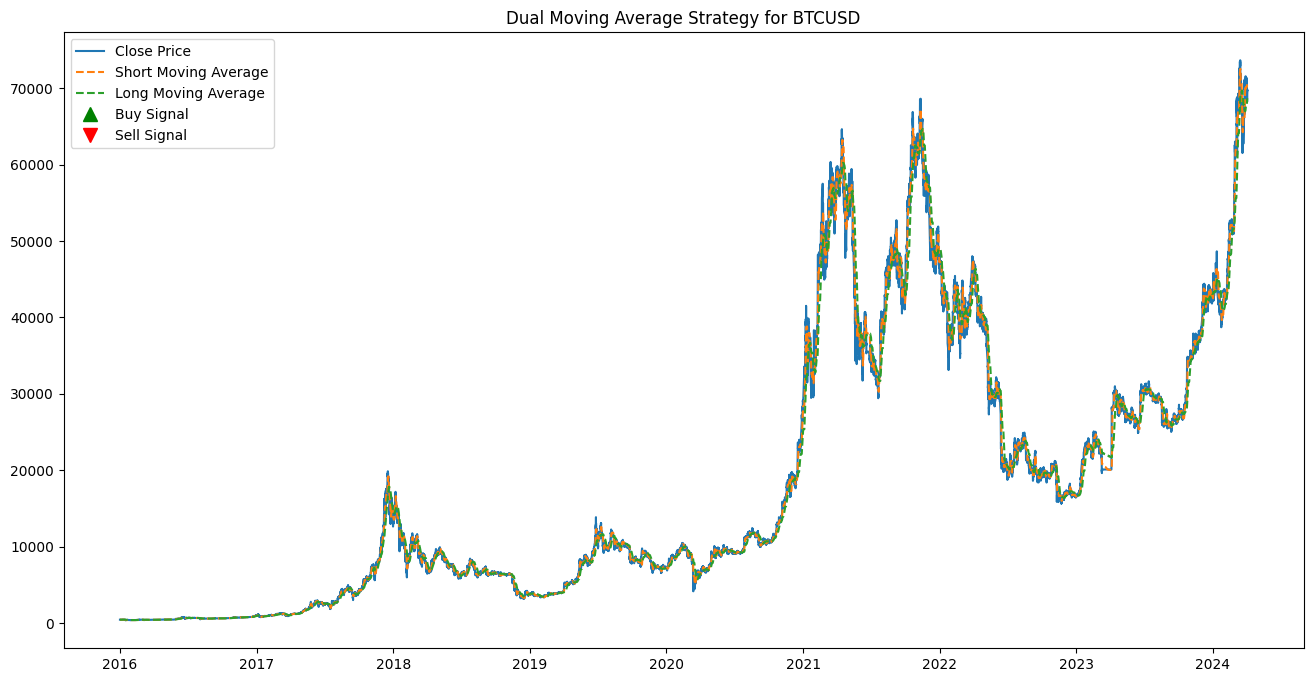

In [ ]:
# Plotting the dual moving average strategy
plt.figure(figsize=(16, 8))  # Adjust the figure size here
plt.plot(df_strategy['close'], label='Close Price')
plt.plot(df_strategy['Short_MA'], label='Short Moving Average', linestyle='--')
plt.plot(df_strategy['Long_MA'], label='Long Moving Average', linestyle='--')
plt.plot(df_strategy[df_strategy['Position'] == 1].index, df_strategy['Short_MA'][df_strategy['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(df_strategy[df_strategy['Position'] == -1].index, df_strategy['Short_MA'][df_strategy['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.legend()
plt.title('Dual Moving Average Strategy for BTCUSD')
plt.show()

Applying Naive trading strategy

In [ ]:
#Creating a function for Naive Momentum Trading
def naive_momentum_trading(df, nb_conseq_days):
    signals = pd.DataFrame(index=df.index)
    signals['orders'] = 0
    cons_day = 0
    prior_price = 0
    init = True
    for k in range(len(df['close'])):
        price = df['close'][k]
        if init:
            prior_price = price
            init = False
        elif price > prior_price:
            if cons_day < 0:
                cons_day = 0
            cons_day += 1
        elif price < prior_price:
            if cons_day > 0:
                cons_day = 0
            cons_day -= 1
        if cons_day == nb_conseq_days:
            signals['orders'][k] = 1
        elif cons_day == -nb_conseq_days:
            signals['orders'][k] = -1
    return signals

In [ ]:
# Apply the naive momentum trading strategy
ts = naive_momentum_trading(df, 5)

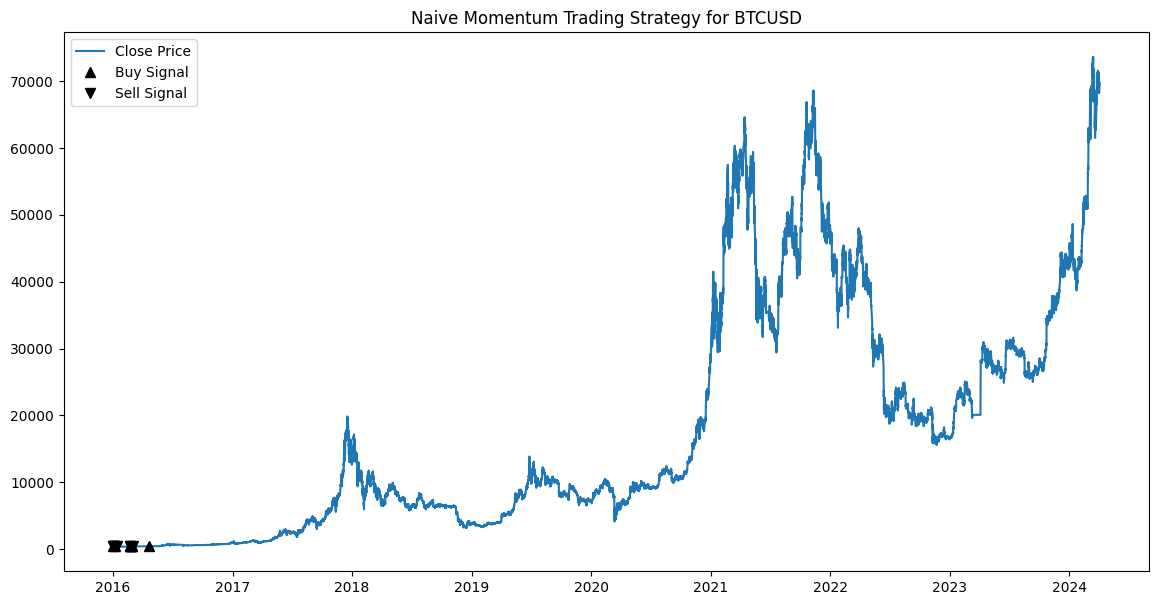

In [ ]:
# Plotting the strategy
plt.figure(figsize=(14,7))
plt.plot(df['close'], label='Close Price')
plt.plot(ts.loc[ts.orders == 1.0].index, df['close'][ts.orders == 1], '^', markersize=7, color='k', label='Buy Signal')
plt.plot(ts.loc[ts.orders == -1.0].index, df['close'][ts.orders == -1], 'v', markersize=7, color='k', label='Sell Signal')
plt.legend()
plt.title('Naive Momentum Trading Strategy for BTCUSD')
plt.show()

Applying Turtle Strategy

In [ ]:
# Turtle Trading Strategy
def turtle_trading(df, window_size):
    signals = pd.DataFrame(index=df.index)
    signals['orders'] = 0
    # window_size-days high
    signals['high'] = df['close'].shift(1).rolling(window=window_size).max()
    # window_size-days low
    signals['low'] = df['close'].shift(1).rolling(window=window_size).min()
    # window_size-days mean
    signals['avg'] = df['close'].shift(1).rolling(window=window_size).mean()

    init = True
    position = 0

    for k in range(len(signals)):
        if df['close'][k] > signals['high'][k] and position == 0:
            signals.orders.values[k] = 1
            position = 1
        elif df['close'][k] < signals['low'][k] and position == 0:
            signals.orders.values[k] = -1
            position = -1
        elif df['close'][k] < signals['avg'][k] and position > 0:
            signals.orders.values[k] = -1
            position = 0
        elif df['close'][k] > signals['avg'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0

    return signals


In [ ]:
# Apply Turtle Trading Strategy
window_size = 50
turtle_signals = turtle_trading(df, window_size)

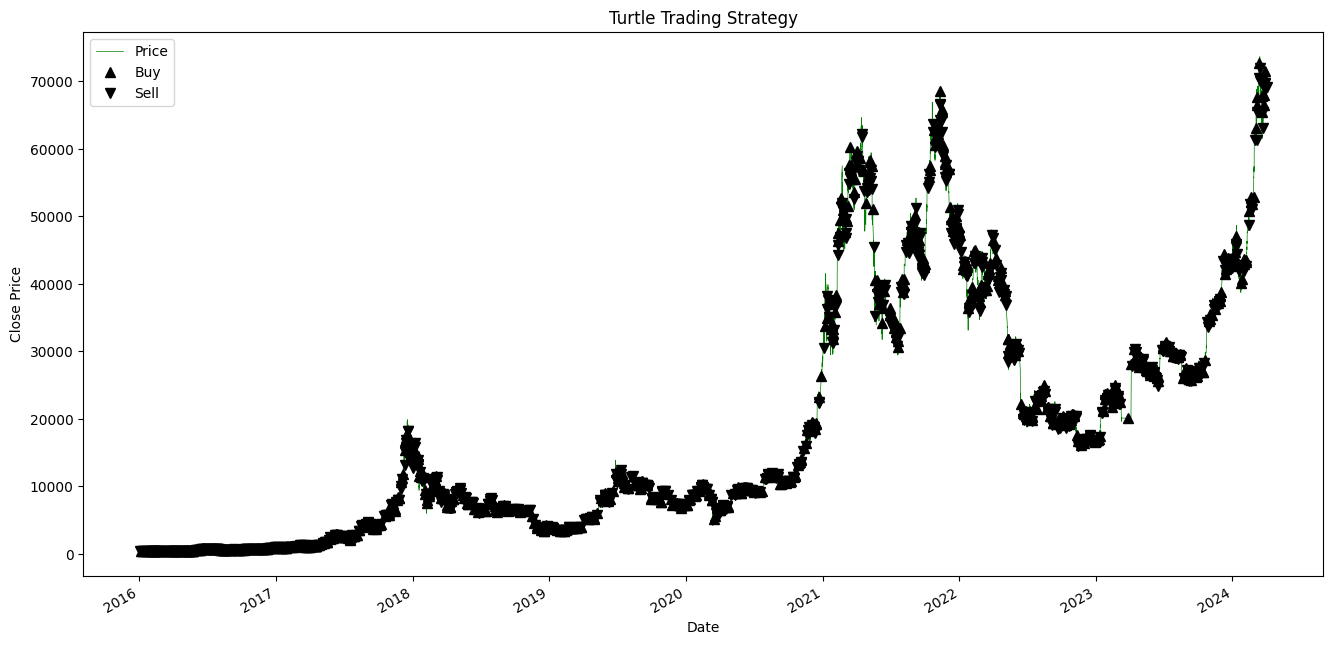

In [ ]:
# Plotting the Turtle Trading Strategy
fig = plt.figure(figsize=(16, 8))  # Adjust the figure size here
ax1 = fig.add_subplot(111, ylabel='Close Price')
df['close'].plot(ax=ax1, color='g', lw=0.5)
ax1.plot(turtle_signals.loc[turtle_signals.orders == 1.0].index,
         df['close'][turtle_signals.orders == 1],
         '^', markersize=7, color='k')
ax1.plot(turtle_signals.loc[turtle_signals.orders == -1.0].index,
         df['close'][turtle_signals.orders == -1],
         'v', markersize=7, color='k')
plt.legend(["Price", "Buy", "Sell"])
plt.title("Turtle Trading Strategy")
plt.show()